In [203]:
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind

from scripts.utils import *
pd.set_option('display.max_rows', None)

def loadcsv_only(homepath, target, stain_type, rett_type):
    loadpath_RETT = f"{homepath}/{target}/features_{rett_type}_RETT_{stain_type}_Resnet10_noavg_ScoreCAM.csv"
    loadpath_CTRL = f"{homepath}/{target}/features_{rett_type}_CTRL_{stain_type}_Resnet10_noavg_ScoreCAM.csv"

    columns_to_use = [10] + list(range(12, 19)) + list(range(20, 22)) + list(range(36, 99))
    # 读取 CSV 文件时仅加载指定的列
    df_RETT = pd.read_csv(loadpath_RETT, usecols=columns_to_use).dropna()  # 删除包含 NaN 的样本
    df_CTRL = pd.read_csv(loadpath_CTRL, usecols=columns_to_use).dropna()  # 删除包含 NaN 的样本

    # 检查数据形状
    print(f"RETT shape: {df_RETT.shape}")
    print(f"CTRL shape: {df_CTRL.shape}")
    return df_RETT, df_CTRL

# Feature ScoreCAM

In [11]:
def validate_ttest(df_RETT, df_CTRL, side):
    # 确保两组数据的特征列名称一致
    assert (df_RETT.columns == df_CTRL.columns).all(), "两组数据的特征列名称不一致"
    
    # 计算独立样本 t 检验，使用 Welch's t 检验
    t_values, p_values = ttest_ind(df_CTRL, df_RETT, equal_var=False)  # 可以假设不等方差
    
    if side == "oneside":
        # 单边检验：假设组1（RETT）的均值大于组2（CTRL）
        p_values = p_values / 2
        # 如果 t 值为负，则取 1 - (p 值 / 2)
        p_values = np.where(t_values < 0, 1 - p_values, p_values)
    elif side == "twoside":
        # 双边检验不需要进一步调整 p 值
        pass
    else:
        raise ValueError("side 参数必须是 'oneside' 或 'twoside'")
        
#     # 进行校正
#     rej, p_values = smm.multipletests(p_values, alpha=1e-100, method='fdr_bh')[:2]
    
    # 创建结果数据框
    results = pd.DataFrame({
        'feature': df_RETT.columns,
        't_value': t_values,
        'p_value': p_values
    })

    # 仅保留 p 值小于 0.01 的特征
    results = results[results['p_value'] < 1e-100]
    
    if side == "oneside":
        # 对 t 值进行从大到小排序
        sorted_filtered_results = results.reindex(results['t_value'].sort_values(ascending=False).index)
    elif side == "twoside":
        # 对 t 值的绝对值进行从大到小排序
        sorted_filtered_results = results.reindex(results['t_value'].abs().sort_values(ascending=False).index)

    # 对 p 值进行从小到大的排序
#     sorted_filtered_results = results.sort_values(by='p_value')

    # 设置显示选项以显示完整结果
    pd.set_option('display.max_rows', None)

    # 输出排序后的结果
    print("按 p 值排序且 p 值小于 1e-100 的特征：", len(sorted_filtered_results))
    # print(sorted_filtered_results)
    # print("-----------------------------------------------------------------------\n")
    
    return sorted_filtered_results

In [204]:
# 定义分类关键词
categories = {
    'Nucleus.Intensity': 'Intensity',
    'Intensity': 'Intensity',
    'Nucleus.Haralick': 'Haralick',
    'Nucleus.Gradient': 'Gradient',
    'Size': 'Size',
    'Shape': 'Shape'
}

# 定义函数来分类特征
def classify_feature(feature):
    for category in categories:
        if category in feature:
            return categories[category]
    return 'Other'

def histgram_categories(df_features, stain_type):
    df_features = pd.DataFrame({'feature': df_features})
    # 对每个特征进行分类
    df_features['category'] = df_features['feature'].apply(classify_feature)

    # 统计每个分类的特征数量
    category_counts = df_features['category'].value_counts()

    # 按固定顺序重新排序
    fixed_order = ['Intensity', 'Haralick', 'Gradient', 'Size', 'Shape']
    category_counts = category_counts.reindex(fixed_order)
    category_counts.fillna(0, inplace=True)

    return category_counts.astype(int)

df_RETT, df_CTRL = loadcsv_only(homepath, target, stain_type, rett_type)
features = df_CTRL.columns.tolist()
total_features = histgram_categories(features, stain_type)
print(total_features)

RETT shape: (3518, 73)
CTRL shape: (1592, 73)
category
Intensity    23
Haralick     26
Gradient      8
Size          4
Shape        12
Name: count, dtype: int64


In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patheffects
from matplotlib.patches import Patch


def plot_stacked_bar(
    total_features: pd.Series,
    important_features: pd.Series,
    title: str = 'H3K27ac ScoreCAM features Importance by Category',
    savepath: str = '/Users/Alpaca/Desktop/Github/disease_epigenome/results_RTT/Classification/new_results'
):

    # -------------------- 数据处理 --------------------
    prop = (important_features / total_features.replace(0, np.nan)).fillna(0)
    df = (
        pd.DataFrame({'Important': prop, 'Nonimportant': 1 - prop})
        .sort_values('Important', ascending=False)
    )
    
    # 新增：为每条记录生成 “类别 (重要/总数)” 的字符串
    df['Label'] = [
        f"{cat} ({int(important_features[cat])}/{int(total_features[cat])})"
        for cat in df.index
    ]

    # -------------------- 配色 ------------------------
    PALETTE = {
        'Important': '#BC3C29',  # 深红
        'Shading': '#FBFBFB'    # 更浅的灰白
    }
    GRID_COLOR = '#D9D9D9'
    SHADOW_HATCH = '///'        # 细斜线，轻盈感
    BAR_H = 0.6

    # -------------------- 字体 ------------------------
    plt.rcParams.update({
        'font.family': 'Arial',
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'axes.linewidth': 1.2,
    })

    # -------------------- 画布 ------------------------
    fig_height = 0.3 * len(df) + 1
    fig, ax = plt.subplots(figsize=(4, fig_height), dpi=300)

    # 背景阴影（斜线 + 更浅底色）
    ax.barh(
        df.index,
        [1] * len(df),
        color=PALETTE['Shading'],
        edgecolor=GRID_COLOR,
        height=BAR_H,
        hatch=SHADOW_HATCH,
        linewidth=0.3,
        zorder=0,
    )

    # 重要部分（去掉边框）
    ax.barh(
        df.index,
        df['Important'],
        color=PALETTE['Important'],
        edgecolor='none',   # 不画边框
        height=BAR_H,
        linewidth=0,        # 线宽设为 0
        zorder=2,
    )

    # -------------------- 坐标轴 ----------------------
    ax.set_xlim(0, 1)
    ax.set_xlabel('Proportion', fontweight='bold', labelpad=6)
    ax.set_yticks(range(len(df)))
    ax.set_yticklabels(df['Label'])   # ← 改这里
    ax.grid(axis='x', color=GRID_COLOR, ls=':', lw=0.8, zorder=1)
    ax.spines[['right', 'top', 'bottom']].set_visible(False)
    ax.tick_params(axis='y', left=False)

    ax.set_title(title, fontweight='bold', loc='left', pad=28)

    # -------------------- 内部标签 --------------------
    for i, (_, row) in enumerate(df.iterrows()):
        pct = row['Important'] * 100
        if pct >= 5:
            ax.text(
                row['Important'] / 2,
                i,
                f'{pct:.0f}%',
                ha='center',
                va='center',
                color='white',
                fontsize=8,
                fontweight='bold',
                path_effects=[patheffects.withStroke(linewidth=2, foreground='#333333')],
                zorder=3,
            )
        elif pct > 0:
            ax.text(
                min(row['Important'] + 0.01, 0.96),
                i,
                f'{pct:.1f}%',
                ha='left',
                va='center',
                color='#555555',
                fontsize=6,
                zorder=3,
            )

    # -------------------- 图例 -----------------------
    legend_elements = [
        Patch(fc=PALETTE['Important'], label='Important'),
        Patch(fc=PALETTE['Shading'], ec=GRID_COLOR, hatch=SHADOW_HATCH, label='Nonimportant'),
    ]
    ax.legend(
        handles=legend_elements,
        frameon=False,
        loc='lower center',
        bbox_to_anchor=(0.5, 1.03),
        ncol=2,
        fontsize=8,
    )

    # -------------------- 保存 / 显示 ---------------
    plt.tight_layout()
    plt.savefig(f"{savepath}/{title}.png", dpi=300)
    plt.show()


👑 ScoreCAM_features - HPS9999 - H3K27ac
RETT shape: (3486, 73)
CTRL shape: (1567, 73)
按 p 值排序且 p 值小于 1e-100 的特征： 46


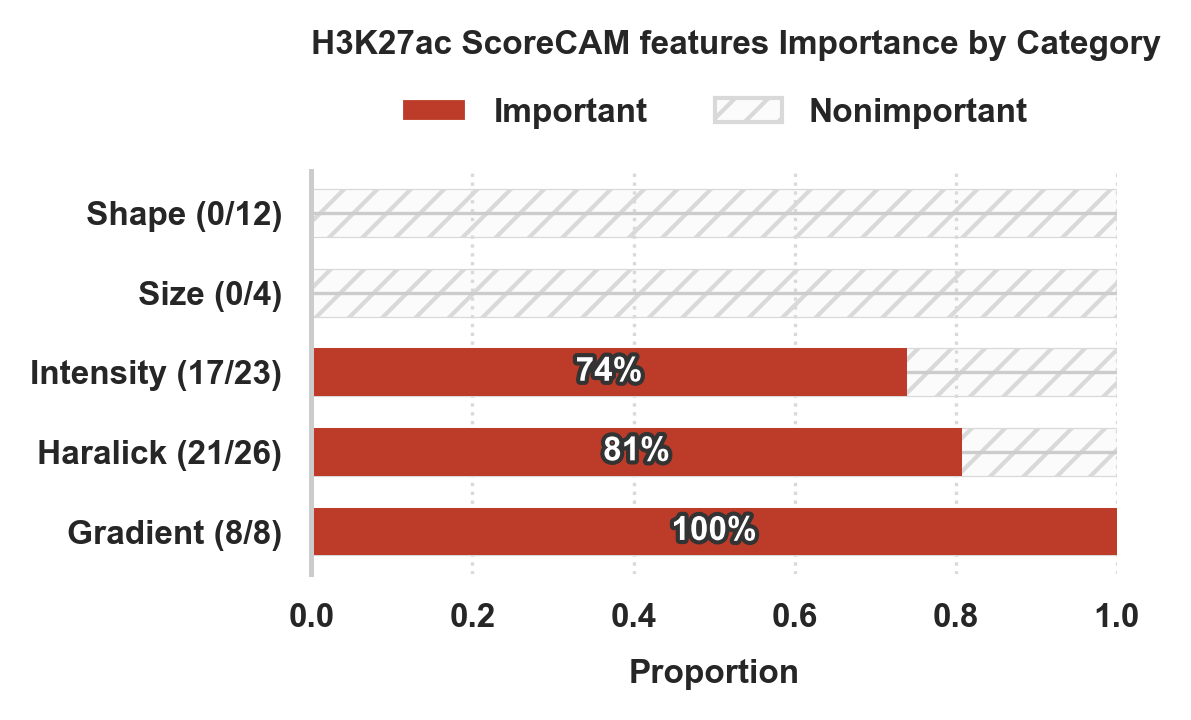

👑 ScoreCAM_features - HPS9999 - CTCF
RETT shape: (3518, 73)
CTRL shape: (1592, 73)
按 p 值排序且 p 值小于 1e-100 的特征： 31


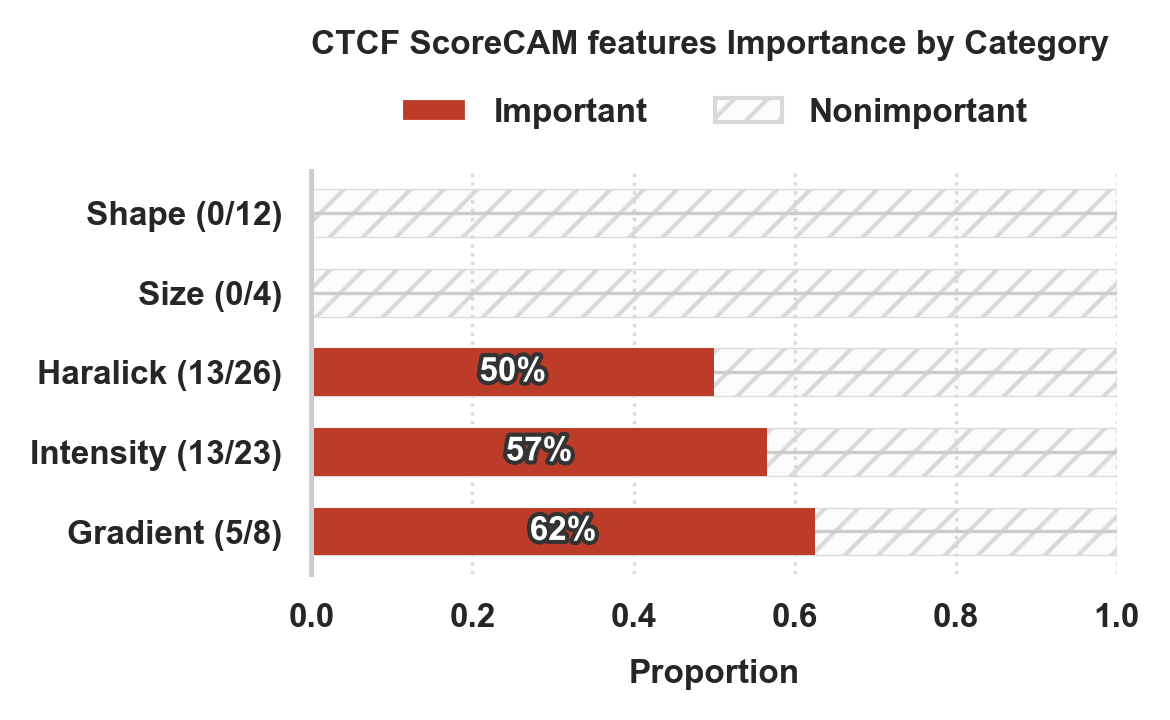

In [202]:
# Two side
for staintype in ["H3K27ac", "CTCF"]:
    print(f"👑 {target} - {retttype} - {staintype}")
    df_RETT, df_CTRL = loadcsv_only(homepath, target, staintype, retttype)
    results = validate_ttest(df_RETT, df_CTRL, "twoside")
    important_features = histgram_categories(results["feature"], staintype)
    plot_stacked_bar(total_features, important_features, 
                 title=f'{staintype} ScoreCAM features Importance by Category')

In [198]:
# target = "ScoreCAM_features"
# retttype = "HPS9999"

# # One side
# for staintype in ["H3K27ac", "CTCF"]:
#     print(f"👑 {target} - {retttype} - {staintype}")
#     df_RETT, df_CTRL = loadcsv_only(homepath, target, staintype, retttype)
#     results = validate_ttest(df_RETT, df_CTRL, "oneside")
#     important_features = histgram_categories(results["feature"], staintype)
#     plot_stacked_bar(total_features, important_features, 
#                  title=f'{staintype} ScoreCAM features Importance by Category')